### Natural Language Processing Script

This script can be used as a standalone program to process and prepare topic modelling of the ```Scraper.py``` datasets generated.

### 1.0 <u>Code:</u>

Here, we import the libraries required to run the script.

In [4]:
'''Natural Language toolkit. Here we download the commonly used English stopwords'''
import nltk; nltk.download('stopwords')
'''Standard set of functions for reading and appending files'''
import re
'''Pandas and numpy is a dependency used by other portions of the code.'''
import numpy as np
import pandas as pd
'''Think this stands for pretty print. Prints out stuff to the terminal in a prettier way'''
from pprint import pprint

'''Contains the language model that has to be developed.'''
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
'''Industrial level toolkit for NLP'''
import spacy

'''Importing OS here to build the directories to hold the status logger logs'''
import os

import pyLDAvis
import pyLDAvis.gensim

'''Importing datetime here to log the time when specfic functions are triggered'''
from datetime import datetime

'''Make pretty visualizations'''
import matplotlib.pyplot as plt

'''Library to log any errors. Came across this in the tutorial.'''
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'com', 'https', 'url', 'link', 'xe', 'abstract', 'author', 'chapter', 'springer', 'title', "the", "of", "and", "in", "to", "a", "is", "for", "from", "with", "that","by", "are", "on", "was", "as", "were", "url:", "abstract:", "abstract",  "author:", "title:", "at", "be", "an", "during", "have", "this", "which", "study", "been", "species", "not", "has", "between", "using", "its", "also", "these", "this", "used", "over", "can", "within", "into", "all","due", "use", "about", "a", 'it', 'their', "where", "we", "most", "may", "through", "though", "like", "or", "further", "e.g.", "along", "any", "those", "had", "toward", "due", "both", "some", "use", "even", "more", "but", "while", "pass", "well", "will", "when", "only", "after", "author", "title", "there", "our", "did", "much", "as", "if", "become", "still", "various", "very", "out", "they", "via", "available", "such", "than", "different", "many", "areas", "no", "one", "two", "small", "first", "other", "such", "-", "could", "studies", "high","provide", "among", "highly", "no", "case", "across", "given", "need", "would", "under", "found", "low", "values", "xe2\\x80\\x89"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sarthak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defining the abstracts log name that will be processed by the rest of the script. The status logger function of the main script has been imported here, and the name of the ```.txt``` file used to log the information has to be added here.

In [2]:
abstracts_log_name = "/home/sarthak/projects/Bias/BackUp_Journal_LOGS/Test_Bed_Atlantic/Cleaned_Atlantic_Forests_CLEANED"
session_folder_name = abstracts_log_name.split('/')[7]
os.makedirs(session_folder_name)
status_logger_name = session_folder_name+"/"+"Status_Logger"+"_"+abstracts_log_name.split('/')[7]

This function is responsible for generating a ```.txt``` file for analysis once the code has run. This code has been copied directly from the ```common_functions.py``` script of the main code.

In [3]:
def status_logger(status_logger_name, status_key):
	'''Status logger to print and log details throught the running the program.
	Declaring current_hour, current_minute & current_second.'''
	current_hour = str(datetime.now().time().hour)
	current_minute = str(datetime.now().time().minute)
	current_second = str(datetime.now().time().second)
	'''Logging the complete_status_key and printing the complete_status_key'''
	complete_status_key = "[INFO]"+current_hour+":"+current_minute+":"+current_second+" "+status_key
	print(complete_status_key)
	status_log = open(status_logger_name+'.txt', 'a')
	status_log.write(complete_status_key+"\n")
	status_log.close()

Here, we read the ```.txt``` file generated from the journal scrapping, that has to be profiled using topic models.

In [4]:
def data_reader(abstracts_log_name, status_logger_name):
	data_reader_start_status_key = abstracts_log_name+".txt is being ported to dataframe"
	status_logger(status_logger_name, data_reader_start_status_key)
	textual_dataframe = pd.read_csv(abstracts_log_name+'.txt', delimiter="\t")
	data_reader_end_status_key = abstracts_log_name+".txt has been ported to dataframe"	
	status_logger(status_logger_name, data_reader_end_status_key)
	return textual_dataframe

Taking the abstracts and preparing a list of abstracts.

In [5]:
def textual_data_trimmer(textual_dataframe, status_logger_name):
	textual_data_trimmer_start_status_key = "Trimming data and preparing list of words"
	status_logger(status_logger_name, textual_data_trimmer_start_status_key)

	'''This function converts the textual data into a list and removes special characters, virtue of email correspondence'''
	textual_data = textual_dataframe.values.tolist()
	print(textual_data)

	textual_data_trimmer_end_status_key = "Trimmed data and prepared list of words"
	status_logger(status_logger_name, textual_data_trimmer_end_status_key)
	return textual_data

Tokenizing the words here and also removing punctuations from the corpus.

In [6]:
def sent_to_words(textual_data, status_logger_name):
	sent_to_words_start_status_key = "Tokenizing words"
	status_logger(status_logger_name, sent_to_words_start_status_key)
	'''This function tokenizes each sentence into individual words; also called tokens'''
	for sentence in textual_data:
		yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
	textual_data = list(sent_to_words(textual_data))
	sent_to_words_end_status_key = "Tokenized words"
	status_logger(status_logger_name, sent_to_words_end_status_key)	
	return textual_data

Generating ***```bigrams```*** from the ```textual_data``` that we have prepared from the abstracts. **Bigrams** are words that occur together, multiple times in a given body of text. For example, *torrential* and *rain* occur together more often with each other, as opposed to other adjective-noun pairs. Hence the two would form a bigram here.

In [7]:
def bigram_generator(textual_data, status_logger_name):
	bigram_generator_start_status_key = "Generating word bigrams"
	status_logger(status_logger_name, bigram_generator_start_status_key)	
	'''Takes the textual data and prepares the bigram, two collectively high frequency words'''
	bigram = gensim.models.Phrases(textual_data, min_count=5, threshold=100)
	bigram_mod = gensim.models.phrases.Phraser(bigram)
	bigram_generator_end_status_key = "Generated word bigrams"
	status_logger(status_logger_name, bigram_generator_end_status_key)	
	return bigram_mod

Here, we use the ```bigram_mod``` model to generate bigrams from our ```corpus```.

In [8]:
def make_bigrams(textual_data, status_logger_name):
	'''Generates multiple bigrams of word pairs in phrases that commonly occuring with each other over the corpus'''
	make_bigrams_start_status_key = "Generating bigrams"
	status_logger(status_logger_name, make_bigrams_start_status_key)

	bigram_mod = bigram_generator(textual_data, status_logger_name)
	return [bigram_mod[doc] for doc in textual_data]

	make_bigrams_end_status_key = "Generated bigrams"

We remove the stopwords, as specified in a list at the start of the program. There's a marked improvement in the topics and keywords produced after expanding the cache of the words to be filtered out.

In [9]:
def remove_stopwords(textual_data, status_logger_name):
	'''This function removes the standard set of stopwords from the corpus of abstract words'''
	remove_stopwords_start_status_key = "Removing stopwords"
	status_logger(status_logger_name, remove_stopwords_start_status_key)
	return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in textual_data]
	remove_stopwords_end_status_key = "Removed stopwords"
	status_logger(status_logger_name, remove_stopwords_end_status_key)

Generating the ```pyLDAvis``` visualization from the ```lda_model``` generated and trained on our ```corpus``` & ```id2word``` dictionary. The time taken here is proportional to the size of the ```corpus```.

In [10]:
def visualizer_generator(lda_model, corpus, id2word, logs_folder_name, status_logger_name):
	'''This code generates the .html file with generates the visualization of the data prepared.'''
	visualizer_generator_start_status_key = "Preparing the topic modeling visualization"
	status_logger(status_logger_name, visualizer_generator_start_status_key)
    
	textual_data_visualization = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
	pyLDAvis.save_html(textual_data_visualization, session_folder_name+'/'+"Data_Visualization_Topic_Modelling.html")

	visualizer_generator_end_status_key = "Prepared the topic modeling visualization"+" "+"Data_Visualization_Topic_Modelling.html"
	status_logger(status_logger_name, visualizer_generator_end_status_key)

Lemmatization involves truncating a term to its root term. For example *running -> run* is an example of the ```lemmatization``` process.

In [11]:
def lemmatization(status_logger_name, textual_data, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
	lemmatization_start_status_key = "Beginning lemmatization"
	status_logger(status_logger_name, lemmatization_start_status_key)
	"""https://spacy.io/api/annotation"""
	texts_out = []
	nlp = spacy.load('en', disable=['parser', 'ner'])
	for sent in textual_data:
		doc = nlp(" ".join(sent))
		texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
	lemmatization_end_status_key = "Ending lemmatization"
	status_logger(status_logger_name, lemmatization_end_status_key)
	return texts_out

Calling the ```nlp_engine_main()``` function where all the previously defined functions come together and generate the ```pyLDAvis``` visualization for topic analysis.

In [12]:
nlp_engine_main_start_status_key = "Initiating the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_start_status_key)

'''Extracts the data from the .txt file and puts them into a Pandas dataframe buckets'''
textual_dataframe = data_reader(abstracts_log_name, status_logger_name)
'''Rids the symbols and special characters from the textual_data'''
textual_data = textual_data_trimmer(textual_dataframe, status_logger_name)
'''Removes stopwords that were earlier downloaded from the textual_data'''
textual_data_no_stops = remove_stopwords(textual_data, status_logger_name)
'''Prepares bigrams'''
textual_data_words_bigrams = make_bigrams(textual_data_no_stops, status_logger_name)
'''Loads the English model from spaCy'''
nlp = spacy.load('en', disable=['parser', 'ner'])

textual_data_lemmatized = lemmatization(status_logger_name, textual_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

id2word = corpora.Dictionary(textual_data_lemmatized)

texts = textual_data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

'''Builds the actual LDA model that will be used for the visualization and inference'''
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = 12, random_state = 100, update_every = 1, chunksize = 100, passes = 10, alpha = 'symmetric', per_word_topics = True)

doc_lda = lda_model[corpus]

perplexity_score = lda_model.log_perplexity(corpus)

perplexity_status_key = "Issued perplexity:"+" "+str(perplexity_score)

status_logger(status_logger_name, perplexity_status_key)

nlp_engine_main_end_status_key = "Idling the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_end_status_key)

[INFO]13:9:49 Initiating the NLP Engine
[INFO]13:9:49 /home/sarthak/projects/Bias/BackUp_Journal_LOGS/Test_Bed_Atlantic/Cleaned_Atlantic_Forests_CLEANED.txt is being ported to dataframe
[INFO]13:9:49 /home/sarthak/projects/Bias/BackUp_Journal_LOGS/Test_Bed_Atlantic/Cleaned_Atlantic_Forests_CLEANED.txt has been ported to dataframe
[INFO]13:9:49 Trimming data and preparing list of words


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO]13:9:57 Generating bigrams
[INFO]13:9:57 Generating word bigrams
[INFO]13:10:7 Generated word bigrams
[INFO]13:10:11 Beginning lemmatization
[INFO]13:11:1 Ending lemmatization
[INFO]13:13:15 Issued perplexity: -10.097034750907598
[INFO]13:13:15 Idling the NLP Engine


In [13]:
lda_model

Presenting the topics of the trained ```LDA``` model here.

In [14]:
lda_model.print_topics()

[(0,
  '0.019*"region" + 0.015*"island" + 0.012*"distribution" + 0.012*"date" + 0.012*"record" + 0.011*"xa" + 0.010*"new" + 0.010*"group" + 0.010*"upper" + 0.010*"present"'),
 (1,
  '0.060*"soil" + 0.025*"concentration" + 0.014*"source" + 0.013*"total" + 0.012*"high" + 0.011*"site" + 0.011*"increase" + 0.011*"carbon" + 0.010*"nutrient" + 0.010*"emission"'),
 (2,
  '0.059*"habitat" + 0.035*"community" + 0.031*"site" + 0.026*"abundance" + 0.025*"diversity" + 0.021*"bird" + 0.021*"composition" + 0.020*"plant" + 0.020*"richness" + 0.018*"assemblage"'),
 (3,
  '0.094*"xa" + 0.081*"forest" + 0.026*"tree" + 0.024*"plant" + 0.021*"crop" + 0.018*"native" + 0.014*"landscape" + 0.012*"measurement" + 0.011*"cover" + 0.010*"loss"'),
 (4,
  '0.074*"population" + 0.017*"genetic" + 0.011*"size" + 0.011*"range" + 0.010*"diversity" + 0.010*"individual" + 0.009*"suggest" + 0.009*"dispersal" + 0.008*"adult" + 0.008*"group"'),
 (5,
  '0.066*"energy" + 0.051*"food" + 0.038*"sequence" + 0.035*"sector" + 0.03

Declaring the ```mallet``` path here. Part of the GitHub package that you've cloned.

In [15]:
mallet_path = '/home/sarthak/projects/Bias/mallet-2.0.8/bin/mallet'

Building the ```LDA mallet``` model here, to generate the representative documents, run the coherence tests and issue perplexity here.

In [16]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=12, id2word=id2word)

Just checking out the topics of the ```LDA mallet``` model here.

In [17]:
pprint(ldamallet.show_topics(formatted=False))

[(4,
  [('research', 0.01952998934016606),
   ('ecological', 0.01527583542781141),
   ('environment', 0.012449512483741309),
   ('knowledge', 0.011892071626260355),
   ('urban', 0.011432427410442725),
   ('process', 0.010767410247132113),
   ('review', 0.0105229186429738),
   ('present', 0.010317545695480818),
   ('natural', 0.009642748868003873),
   ('human', 0.009280901293849569)]),
 (9,
  [('soil', 0.05461599681655392),
   ('concentration', 0.02286293094092537),
   ('total', 0.015211807690916327),
   ('high', 0.012570994465144883),
   ('nutrient', 0.011603299207756032),
   ('source', 0.010762218283109647),
   ('site', 0.010707954997648591),
   ('level', 0.009414680027493398),
   ('rate', 0.008682125673769128),
   ('sample', 0.007813913106392215)]),
 (1,
  [('model', 0.04139188873515301),
   ('datum', 0.03171551274909705),
   ('base', 0.023809095973118182),
   ('method', 0.017007780632872723),
   ('estimate', 0.015911663761657473),
   ('analysis', 0.014995238180805377),
   ('result',

Presenting the "Coherence" of the model here. Coherence is a proxy for how well the model has been built and trained.

In [18]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=textual_data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5066059444090882


Presenting the coherence here for a bunch of trained models. Will be eventually selecting the ```optimal_model``` as the ```lda_model```, to get the representative documents with corresponding ```num_topics```.

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

Computing coherence from the previously generated ```mallet``` models, to find the model with the best coherence, and thereby the best model.

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=textual_data_lemmatized, start=2, limit=40, step=6)

Plotting the computed coherence scores here for the models that we generated.

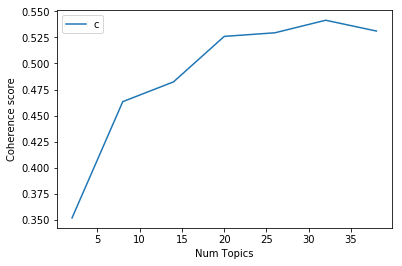

In [21]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Declaring the ```optimal_model``` as the previously generated ```ldamallet``` model.

In [22]:
optimal_model = ldamallet

Presenting the topics of the ```ldamallet``` model here.

In [23]:
model_topics = optimal_model.show_topics(formatted=False)
print(model_topics)

[(7, [('forest', 0.12583808844507846), ('tree', 0.035993223965763196), ('plant', 0.0237339514978602), ('vegetation', 0.015335235378031383), ('fragment', 0.013034950071326675), ('native', 0.01130527817403709), ('stand', 0.011046718972895863), ('fire', 0.010493937232524965), ('tropical', 0.010431526390870185), ('atlantic', 0.010413694721825963)]), (11, [('land', 0.04400835710401542), ('change', 0.03660526039629464), ('increase', 0.029641007050114004), ('impact', 0.029135383177035137), ('ecosystem', 0.020501617042386545), ('system', 0.019146926665458256), ('loss', 0.017439253584682457), ('production', 0.013766325450052947), ('agricultural', 0.012888638726972648), ('potential', 0.012774157850049131)]), (9, [('soil', 0.05461599681655392), ('concentration', 0.02286293094092537), ('total', 0.015211807690916327), ('high', 0.012570994465144883), ('nutrient', 0.011603299207756032), ('source', 0.010762218283109647), ('site', 0.010707954997648591), ('level', 0.009414680027493398), ('rate', 0.00868

```num_words``` dictates the number of keywords to be presented with each topic.

In [ ]:
pprint(optimal_model.print_topics(num_topics = -1, num_words=40))

This function computes the dominant topic in each sentence. We use this meta-data as a part of our framework to understand under which areas of research do the publications fall in, and also to label each of the ```pyLDAvis``` topics.

In [25]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=textual_data):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

Generating the ```dataframes``` here which contains the dominant topics for each abstract.

In [26]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=textual_data)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.2219,"forest, tree, plant, vegetation, fragment, nat...",['Efforts to conserve tropical forests could b...
1,1,8.0,0.2685,"conservation, management, environmental, resou...",['The Brazilian Atlantic Forest is a highly th...
2,2,7.0,0.1877,"forest, tree, plant, vegetation, fragment, nat...",['Floristic differentiation and vegetation def...
3,3,11.0,0.2254,"land, change, increase, impact, ecosystem, sys...",['Global trends of increasing migration and po...
4,4,4.0,0.2082,"research, ecological, environment, knowledge, ...",['This study focuses on knowledge of medicinal...
5,5,3.0,0.2495,"population, genetic, diversity, group, analysi...",['A population viability analysis (PVA) using ...
6,6,7.0,0.3889,"forest, tree, plant, vegetation, fragment, nat...",['The Brazilian Atlantic Forest suffered a sev...
7,7,1.0,0.2060,"model, datum, base, method, estimate, analysis...",[Atlantic Forest encompasses a high level of b...
8,8,7.0,0.3473,"forest, tree, plant, vegetation, fragment, nat...",['The Brazilian Atlantic Forest (sensu lato) i...
9,9,7.0,0.2280,"forest, tree, plant, vegetation, fragment, nat...",[The causes of the degradation of Brazilian At...


Saving the ```dataframe``` to disc for analysis.

In [27]:
df_dominant_topic.to_csv(session_folder_name+'/Master_Topic_Per_Centence.csv')

Here we find the most representative document for each topic, and contain it in a ```dataframe``` and save it as a ```.csv```

In [28]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

In [29]:
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet.head()
sent_topics_sorteddf_mallet.to_csv(session_folder_name+'/Master_Topics_Contribution.csv')

Here, we find the number of documents for each topic.

In [30]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

Here, we find the percentage of documents falling under each topic.

In [31]:
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

Presenting the dominant topics in each sentence here.

In [32]:
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,7.0,"forest, tree, plant, vegetation, fragment, nat...",1787.0,0.1419
1,8.0,"conservation, management, environmental, resou...",844.0,0.0670
2,7.0,"forest, tree, plant, vegetation, fragment, nat...",1043.0,0.0829
3,11.0,"land, change, increase, impact, ecosystem, sys...",1240.0,0.0985
4,4.0,"research, ecological, environment, knowledge, ...",880.0,0.0699
5,3.0,"population, genetic, diversity, group, analysi...",743.0,0.0590
6,7.0,"forest, tree, plant, vegetation, fragment, nat...",868.0,0.0689
7,1.0,"model, datum, base, method, estimate, analysis...",1040.0,0.0826
8,7.0,"forest, tree, plant, vegetation, fragment, nat...",1449.0,0.1151
9,7.0,"forest, tree, plant, vegetation, fragment, nat...",1287.0,0.1022


Saving it to a ```.csv``` bucket here.

In [33]:
df_dominant_topics.to_csv(session_folder_name+'/Master_Topics.csv')

Generating the visualization here from the ```lda_model```. We use this to label the broad areas of research, in syn which the representative documents generated above.

In [34]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/home/sarthak/.local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Enabling the visualizations in the notebook here.

In [35]:
pyLDAvis.enable_notebook()

Saving the visualization to the disk, as an ```.html``` file in the sessions folder.

In [36]:
pyLDAvis.save_html(vis, session_folder_name+'/Master.html')

Presenting the ```pyLDAvis``` visualization here.

In [37]:
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
8      34.369499        1       1  0.254786 -0.064971
9      15.095896        1       2  0.169449 -0.273586
1       8.224251        1       3  0.120197  0.161626
3       7.166303        1       4  0.060179  0.049715
0       6.788846        1       5  0.070334 -0.117695
2       6.674170        1       6  0.080436  0.143275
10      6.618900        1       7 -0.028428 -0.173377
4       6.249713        1       8  0.065698  0.119294
7       5.792520        1       9  0.049662  0.207394
5       1.539923        1      10 -0.259809 -0.027645
6       0.794967        1      11 -0.291203 -0.009931
11      0.685019        1      12 -0.291301 -0.014100, topic_info=      Category          Freq                Term         Total  loglift  \
40756  Default  10054.000000                  xa  10054.000000  30.0000   
32960  Default   7883.000000              forest   7883.000000  29.0000   
30446  Default   6211.000000          population   6211.000000  28.0000   
7536   Default   6323.000000               water   6323.000000  27.0000   
27722  Default   6670.000000                soil   6670.000000  26.0000   
7952   Default   6477.000000             habitat   6477.000000  25.0000   
39262  Default   4260.000000           community   4260.000000  24.0000   
25747  Default   5572.000000                site   5572.000000  23.0000   
26282  Default   4320.000000                year   4320.000000  22.0000   
50496  Default   7572.000000               model   7572.000000  21.0000   
533    Default   2933.000000               river   2933.000000  20.0000   
34422  Default   1942.000000              energy   1942.000000  19.0000   
30689  Default   4990.000000               plant   4990.000000  18.0000   
36578  Default   4769.000000              region   4769.000000  17.0000   
46340  Default   7227.000000              change   7227.000000  16.0000   
50529  Default   6550.000000            increase   6550.000000  15.0000   
27487  Default   2769.000000       concentration   2769.000000  14.0000   
26632  Default   3450.000000                tree   3450.000000  13.0000   
30385  Default   2350.000000           abundance   2350.000000  12.0000   
3270   Default   3208.000000           diversity   3208.000000  11.0000   
40277  Default   2846.000000             coastal   2846.000000  10.0000   
37233  Default   2217.000000                fish   2217.000000   9.0000   
7686   Default   2765.000000            resource   2765.000000   8.0000   
27174  Default   4502.000000          management   4502.000000   7.0000   
31878  Default   1994.000000              growth   1994.000000   6.0000   
16363  Default   2203.000000              marine   2203.000000   5.0000   
6816   Default   1090.000000                risk   1090.000000   4.0000   
21988  Default   2815.000000                rate   2815.000000   3.0000   
16127  Default   5147.000000       environmental   5147.000000   2.0000   
49180  Default   3179.000000        distribution   3179.000000   1.0000   
...        ...           ...                 ...           ...      ...   
12327  Topic12    259.435455             pacific    260.446747   4.9796   
39781  Topic12    245.538666                meet    246.549927   4.9794   
35649  Topic12    245.196518                burn    246.207764   4.9794   
24934  Topic12    219.738541                 usa    220.749802   4.9789   
10920  Topic12    178.532272            mitigate    179.543533   4.9778   
49123  Topic12    173.278534             utilize    174.289825   4.9777   
15753  Topic12    153.507111            pathogen    154.518372   4.9769   
13273  Topic12    130.810791                tick    131.822037   4.9758   
17136  Topic12    126.716263             ethanol    127.727516   4.9755   
26303  Topic12    125.113342           encounter    126.124649   4.9754   
14613  Topic12    120.917984           elsewhere   

In [38]:
topics = optimal_model.show_topics(num_topics = -1, formatted=False)

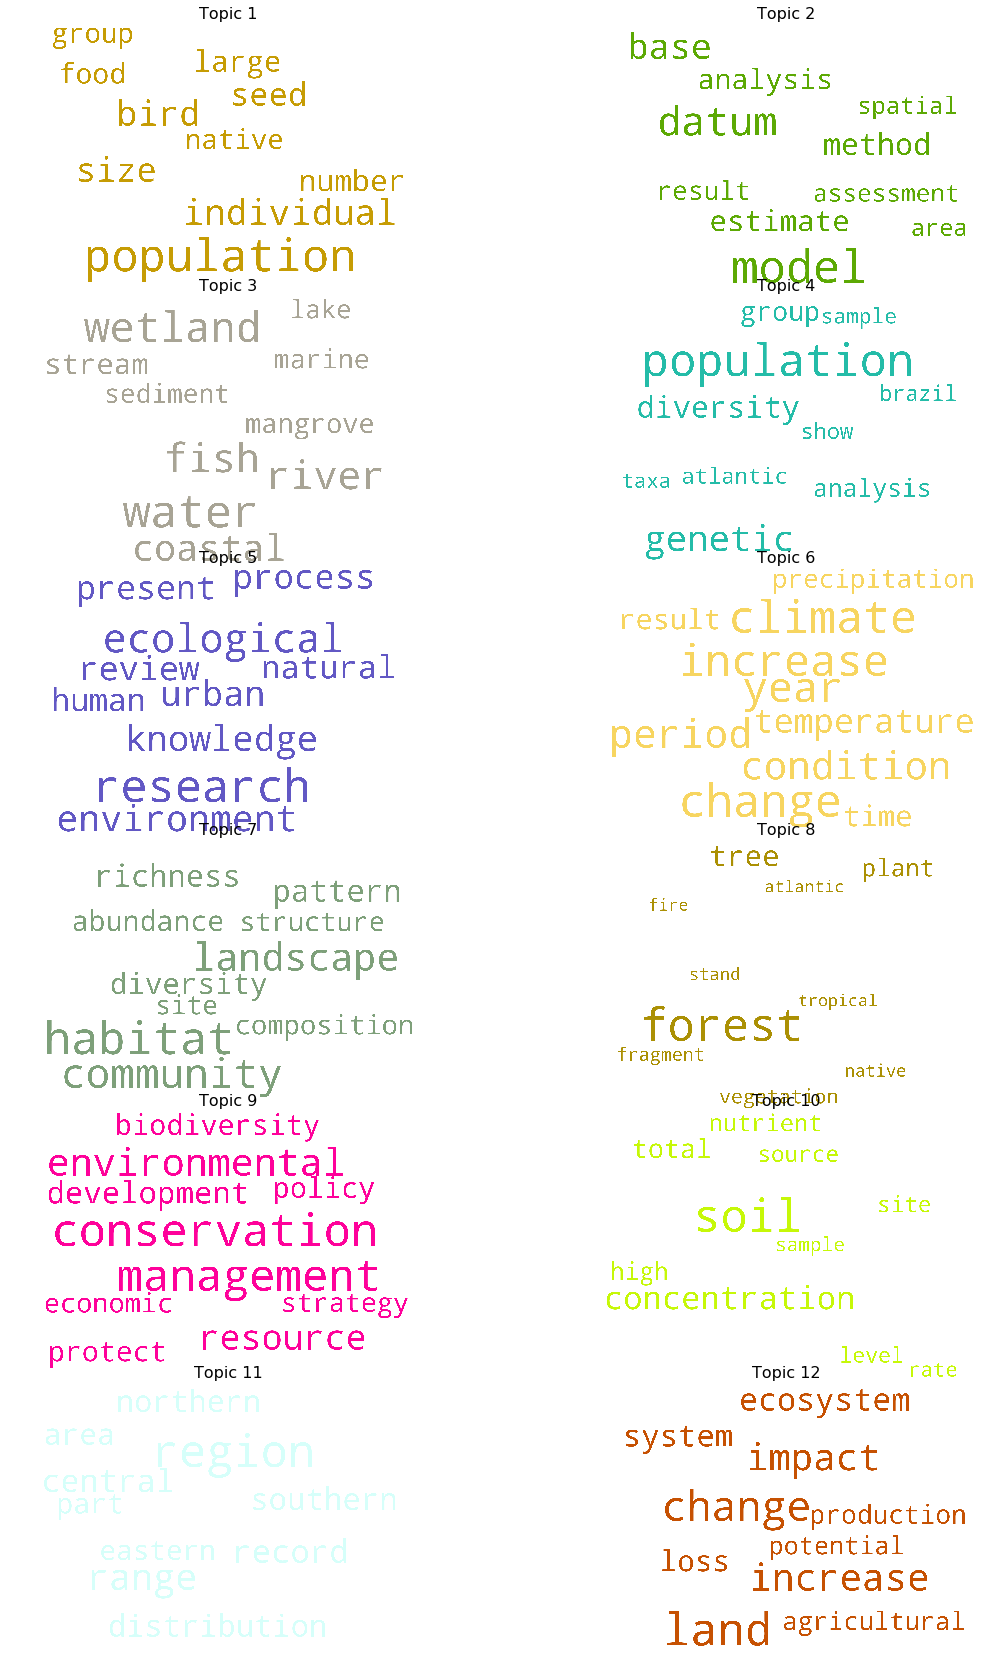

In [39]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab8',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(6, 2, figsize = (20, 30), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

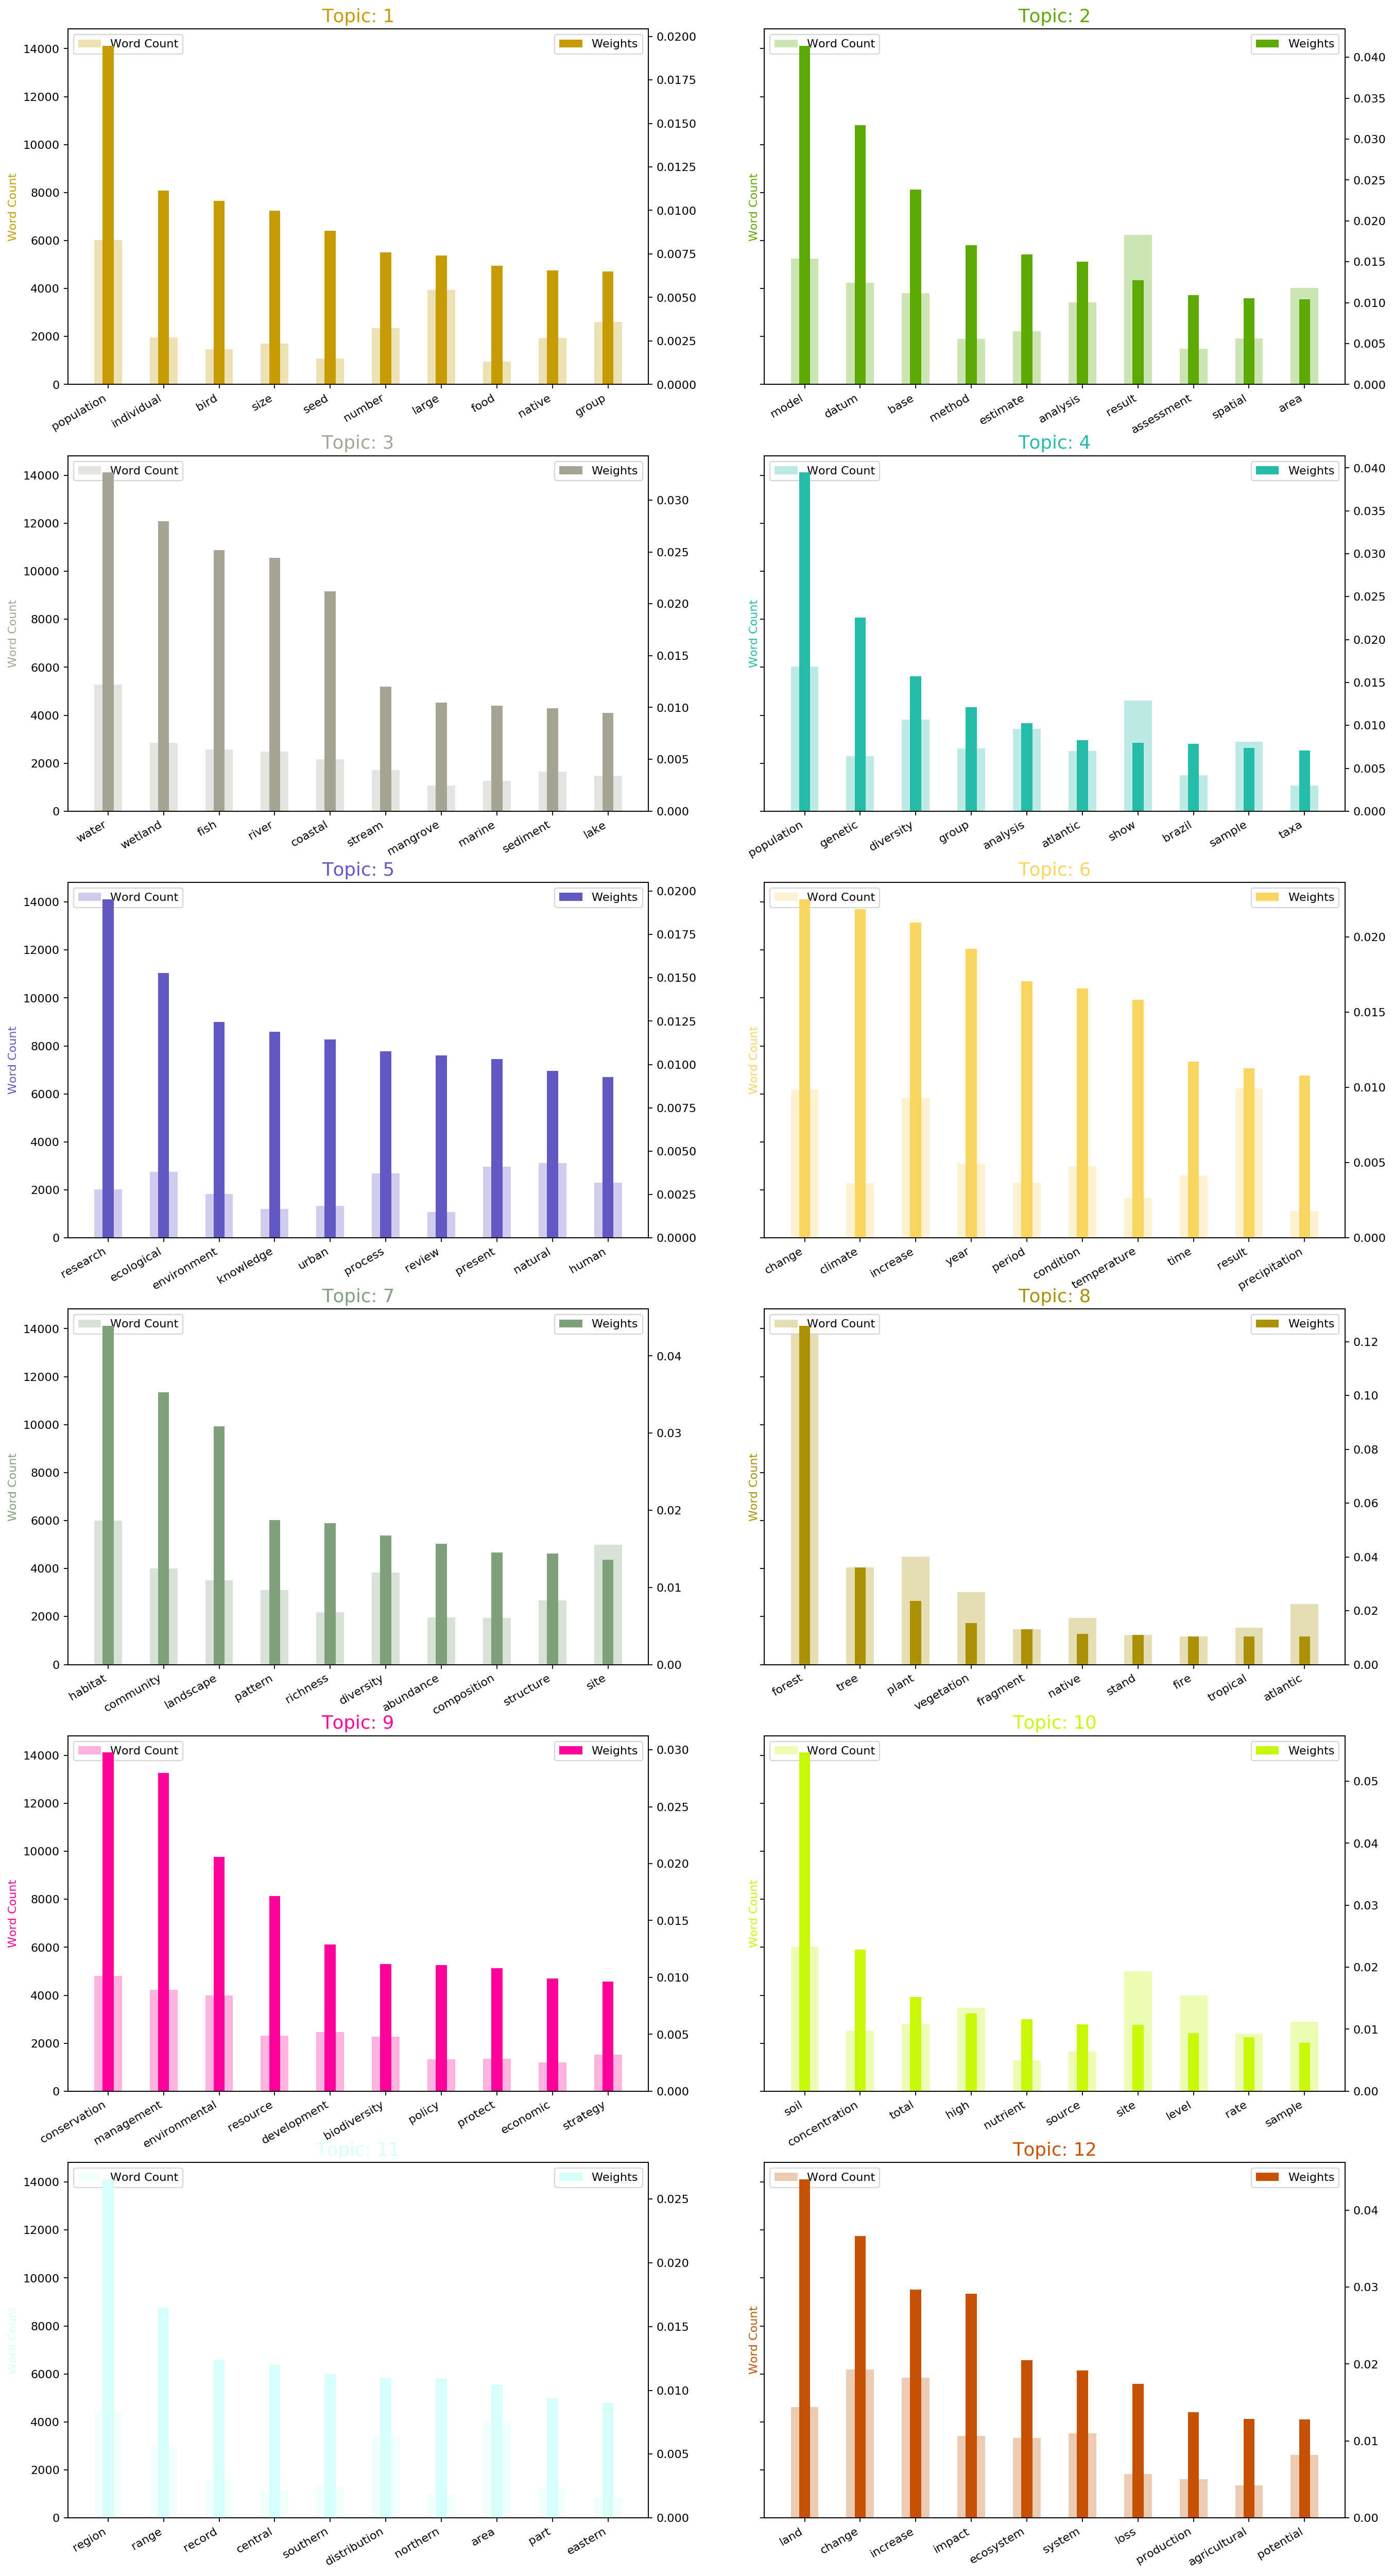

In [40]:
from collections import Counter
topics = optimal_model.show_topics(num_topics = -1, formatted=False)
data_flat = [w for w_list in textual_data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(6, 2, figsize=(20, 40), sharey=True, dpi=160)
cols = [color for name, color in mcolors.XKCD_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=True)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
plt.savefig('ForestsCorpus12.pdf')
plt.show()